Generate all the guest graphs and pickle them

In [ ]:
from ember.sample import *
import pickle

edge_densities = ["low", "medium", "high"]

guest_generators = {
    "barabasi_albert": barabasi_albert_graph,
}
seeds = [10, 20, 30, 40, 50]

all_guests = {}

for graph_type, generator in guest_generators.items():
    print(f"Generating graph type: {graph_type}")
    all_guests[graph_type] = {}
    for edge_density in edge_densities:
        all_guests[graph_type][edge_density] = {}
        for num_nodes in range(10, 96):
            all_guests[graph_type][edge_density][num_nodes] = {}
            for i, seed in enumerate(seeds):
                all_guests[graph_type][edge_density][num_nodes][i] = generator(
                    num_nodes, edge_density, seed)

    with open(f'guests/{graph_type}.pickle', 'wb') as handle:
        pickle.dump(all_guests[graph_type], handle, protocol=pickle.HIGHEST_PROTOCOL)


Load the guest graphs from the pickles

In [2]:
import pickle

guest_types = {
    "barabasi_albert",
    "d_regular",
    "erdos_reyni",
    "noisy_bipartite"
}

all_guests = {}

for graph_type in guest_types:
     with open(f'guests/{graph_type}.pickle', 'rb') as handle:
            all_guests[graph_type] = pickle.load(handle)


Draw some graphs to check

980

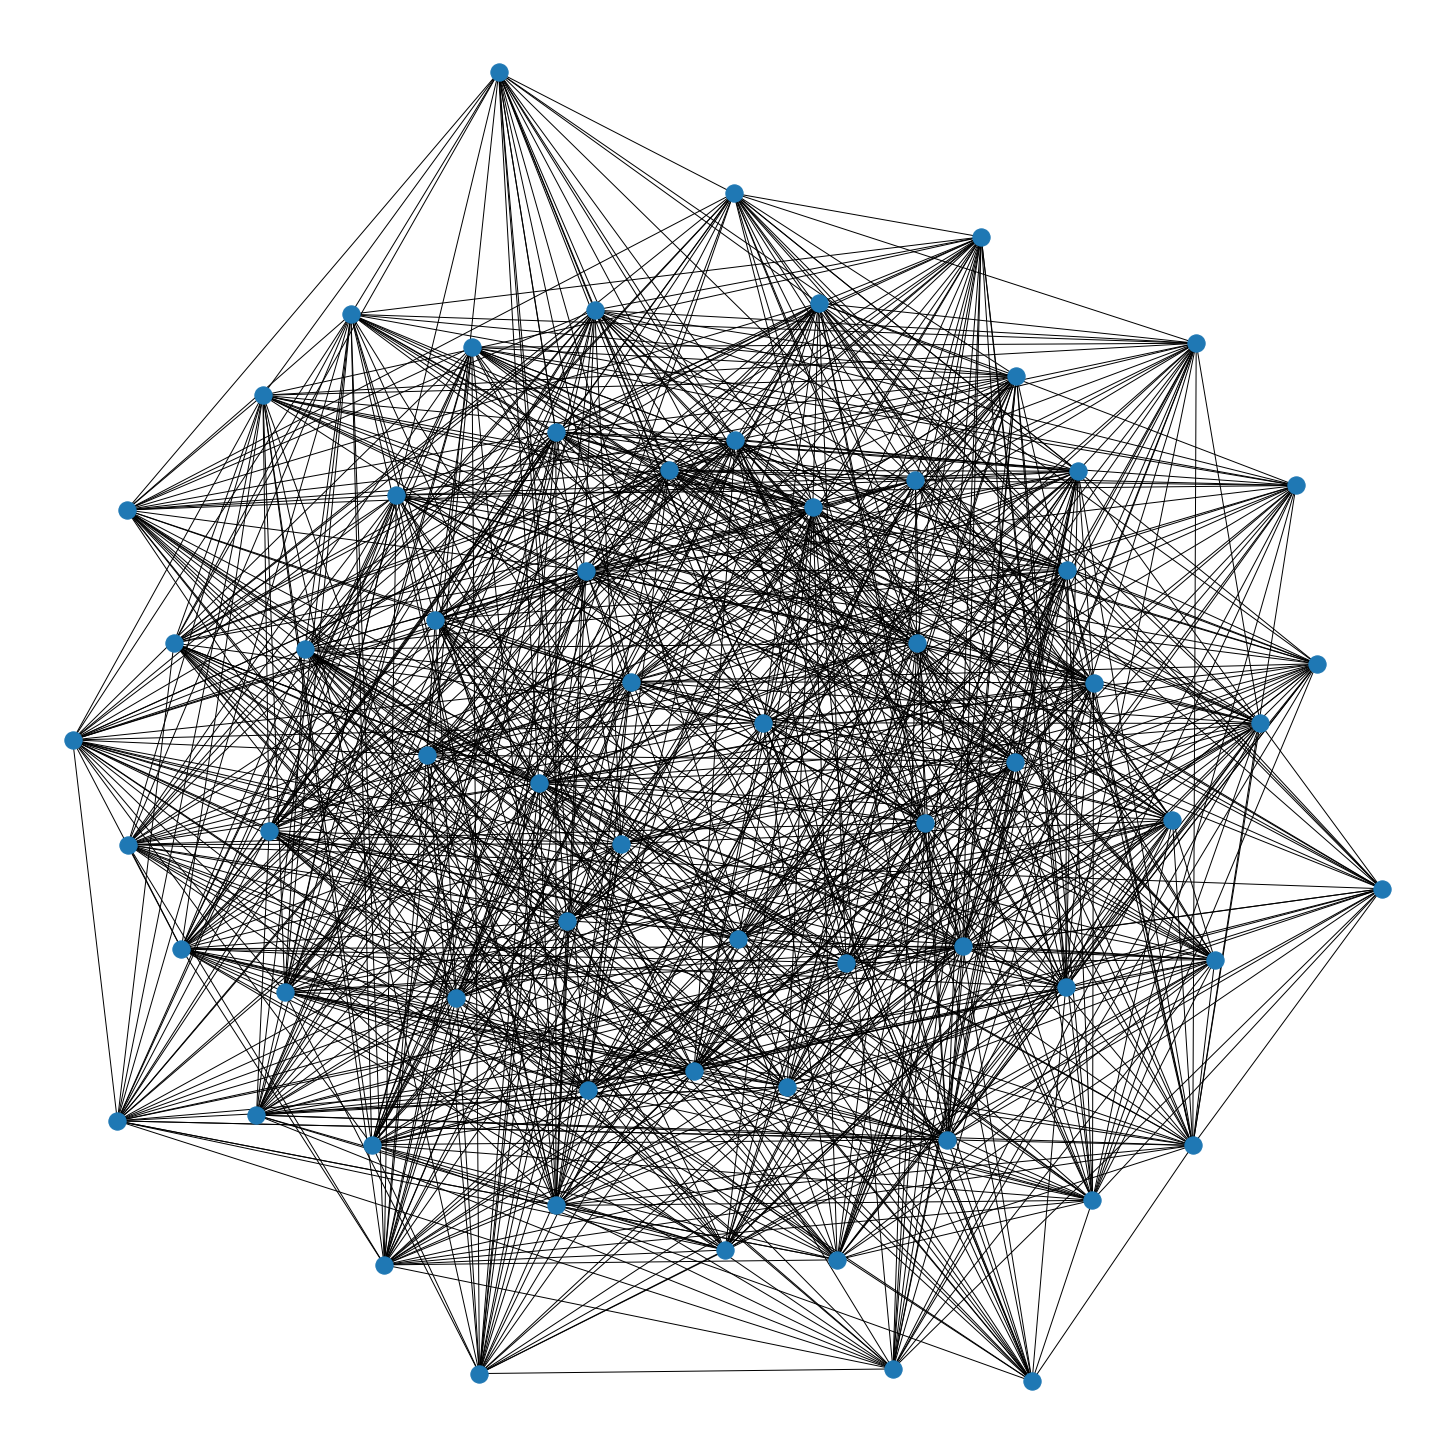

In [3]:
from matplotlib import pyplot as plt
import networkx as nx

plt.ion()
plt.figure(figsize=(20, 20))
g =all_guests["noisy_bipartite"]["high"][65][2]
nx.draw(g)

len(g.edges)

Start of benchmarking

In [ ]:
non_faulty_results = {}
faulty_results = {}

def get_chain_stats(emb):
    length = [len(chain) for chain in emb.values()]
    length = sorted(length)
    max_length = length[-1]
    mid = len(length) // 2
    median_length = (length[mid] + length[~mid]) / 2
    qubits_used = sum(length)
    return max_length, median_length, qubits_used



Non-faulty test harness

In [ ]:
from ember.util import *
from ember.hardware.chimera import D_WAVE_2000Q
import time

host = D_WAVE_2000Q()

def run_benchmark(embed_func):
    results = {}
    for graph_type in ["barabasi_albert", "d_regular", "erdos_reyni", "noisy_bipartite"]:
        print(f"graph type: {graph_type}")
        results[graph_type] = {}
        for density in ["low","medium", "high"]:
            print(f"density : {density}")
            results[graph_type][density] = {}
            for size in range(65, 96):
                print(f"size:  {size}")
                found = False
                for instance in range(5):
                    guest = all_guests[graph_type][density][size][instance]
                    start_time = time.time()
                    emb = embed_func(guest, host)
                    total = time.time() - start_time
                    if check_embedding(emb, guest, host):
                        found = True
                        max_chain, median_length, qubits_used = get_chain_stats(emb)
                        data = {
                            "max_chain_length": max_chain,
                            "median_chain_length": median_length,
                            "qubits_used": qubits_used,
                            "walltime": total}
                        print(data)
                        results[graph_type][density][size] = data
                        break
                if not found:
                    break
    return results

Minorminer

In [ ]:
from minorminer import find_embedding

def minor_miner_embed_func(guest, host):
    return find_embedding(guest, host, tries=1)

non_faulty_results["minorminer"] = run_benchmark(minor_miner_embed_func)

with open('results/non_faulty_minorminer.pickle', 'wb') as handle:
    pickle.dump(non_faulty_results["minorminer"], handle, protocol=pickle.HIGHEST_PROTOCOL)

PSSA

In [ ]:
from ember.pssa.optimize import run_simulated_annealing
from ember.pssa.model import ProbabilisticSwapShiftModel
from ember.hardware.chimera import D_WAVE_2000Q
import random

T_MAX = 10**6

def pssa_schedule(iter_count):
    progress_ratio = iter_count / T_MAX
    if 0 <= iter_count < (T_MAX // 2):
        temperature = 0.603 * (1 - 2 * progress_ratio)
    else:
        temperature = 0.334 * 2 * (1 - progress_ratio)
    shift = random.random() < min(1.2 * progress_ratio, 0.7)
    if shift:
        if progress_ratio < 0.5:
            any_dir = random.random() < progress_ratio * 0.8
        else:
            any_dir = True
    else:
        any_dir = False
    return temperature, shift, any_dir

def pssa_func(guest, host):
    model = ProbabilisticSwapShiftModel(guest, host)
    return run_simulated_annealing(model, pssa_schedule, T_MAX)


non_faulty_results["pssa"] = run_benchmark(pssa_func)

with open('results/non_faulty_pssa.pickle', 'wb') as handle:
    pickle.dump(non_faulty_results["pssa"], handle, protocol=pickle.HIGHEST_PROTOCOL)

COA

In [ ]:
from ember.pssa.optimize import run_simulated_annealing
from ember.pssa.model import CliqueOverlapModel
import random

T_MAX = 10**6

def coa_schedule(iter_count):
    progress_ratio = iter_count / T_MAX
    if 0 <= iter_count < (T_MAX // 2):
        temperature = 0.603 * (1 - 2 * progress_ratio)
    else:
        temperature = 0.334 * 2 * (1 - progress_ratio)
    shift = random.random() > ((0.3 * progress_ratio - 1) ** 2)
    return temperature, shift, None

def coa_func(guest, host):
    model = CliqueOverlapModel(guest, host)
    return run_simulated_annealing(model, coa_schedule, T_MAX)

non_faulty_results["coa"] = run_benchmark(coa_func)

with open('results/non_faulty_coa.pickle', 'wb') as handle:
    pickle.dump(non_faulty_results["coa"], handle, protocol=pickle.HIGHEST_PROTOCOL)

Fault-tolerant test harness

In [ ]:
from ember.util import *
import time


def run_benchmark2(host_name, alg_name, host, embed_func):
    results = {}
    count = 0
    for graph_type in ["barabasi_albert", "d_regular", "erdos_reyni", "noisy_bipartite"]:
        print(f"graph type: {graph_type}")
        results[graph_type] = {}
        for density in ["low", "medium", "high"]:
            with open(f'checkpoint2/{host_name}_{alg_name}_{count}.pickle', 'wb') as handle:
                pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
            count += 1
            print(f"density : {density}")
            results[graph_type][density] = {}
            for size in range(10, 65):
                print(f"size:  {size}")
                found = False
                for instance in range(5):
                    guest = all_guests[graph_type][density][size][instance]
                    # start_time = time.time()
                    try:
                        emb, walltime = embed_func(guest, host)
                    except:
                        print("Failed! skipping.....")
                        break
                    # total = time.time() - start_time
                    if check_embedding(emb, guest, host):
                        found = True
                        max_chain, median_length, qubits_used = get_chain_stats(emb)
                        data = {
                            "max_chain_length": max_chain,
                            "median_chain_length": median_length,
                            "qubits_used": qubits_used,
                            "walltime": walltime}
                        print(data)
                        results[graph_type][density][size] = data
                        break
                if not found:
                    break
    return results

Fault-tolerant benchmarks

In [ ]:
from ember.template import BipartiteSat, QuadripartiteSat
from ember.hardware.chimera import D_WAVE_2000Q_6, D_WAVE_2000Q_QuAIL, D_WAVE_2000Q
from minorminer import find_embedding

def bte_func(guest, host):
    emb, walltime = BipartiteSat(guest, host).solve(return_walltime=True, timeout=30)
    return emb, walltime

def qte_func(guest, host):
    emb, walltime = QuadripartiteSat(guest, host).solve(return_walltime=True, timeout=30)
    return emb, walltime

def minor_miner_embed_func(guest, host):
    return find_embedding(guest, host, tries=1)

non_faulty = D_WAVE_2000Q()
faulty1 = D_WAVE_2000Q_6()
faulty2 = D_WAVE_2000Q_QuAIL()

nf_bte = run_benchmark2("nonfaulty", "bte", non_faulty, bte_func)
with open('results/nonfaulty_bte.pickle', 'wb') as handle:
    pickle.dump(nf_bte, handle, protocol=pickle.HIGHEST_PROTOCOL)

nf_qte = run_benchmark2("nonfaulty", "qte", non_faulty, qte_func)
with open('results/nonfaulty_qte.pickle', 'wb') as handle:
    pickle.dump(nf_qte, handle, protocol=pickle.HIGHEST_PROTOCOL)

f1_mm = run_benchmark2("faulty1", "mm", faulty1, minor_miner_embed_func)
with open('results/faulty1_minorminer.pickle', 'wb') as handle:
    pickle.dump(f1_mm, handle, protocol=pickle.HIGHEST_PROTOCOL)

f2_mm = run_benchmark2("faulty2", "mm", faulty2, minor_miner_embed_func)
with open('results/faulty2_minorminer.pickle', 'wb') as handle:
    pickle.dump(f2_mm, handle, protocol=pickle.HIGHEST_PROTOCOL)

f1_bte = run_benchmark2("faulty1", "bte", faulty1, bte_func)
with open('_results/faulty1_bte.pickle', 'wb') as handle:
    pickle.dump(f1_bte, handle, protocol=pickle.HIGHEST_PROTOCOL)

f2_bte = run_benchmark2("faulty2","bte", faulty2, bte_func)
with open('results/faulty2_bte.pickle', 'wb') as handle:
    pickle.dump(f2_bte, handle, protocol=pickle.HIGHEST_PROTOCOL)

f1_qte = run_benchmark2("faulty1","qte", faulty1, qte_func)
with open('results/faulty1_qte.pickle', 'wb') as handle:
    pickle.dump(f1_qte, handle, protocol=pickle.HIGHEST_PROTOCOL)

f2_qte = run_benchmark2("faulty2","qte", faulty2, qte_func)
with open('results/faulty2_qte.pickle', 'wb') as handle:
    pickle.dump(f2_qte, handle, protocol=pickle.HIGHEST_PROTOCOL)

